# N04: DATA ANALYSIS: Preparing The Data And First Analysis

## Notebook Description

After extracting the data and loading it into the database, it is valuable to review the dataset from a broad perspective to uncover hidden insights and identify its potential value.  

The exploration begins with the central database: `flight`, with a particular focus on the variable `dep_delay`, which represents the departure delay for flights.  

In the subsequent steps:  
**1.** The initial dataset is prepared for analysis  
**2.** Additional information, such as `weather data`, is incorporated to provide a more comprehensive context  

By analyzing the data and drawing meaningful conclusions, it becomes possible to propose a **reporting system** to support decision-making processes.

###
## Notebook Configuration

<p style='background-color: #FFFFE0; margin-top:20px; padding:5px 15px; font-weight: 500'>Libraries import</p>

In [1]:
from psycopg2 import connect
import pandas as pd
import matplotlib.pyplot as plt
import os
from project_dir import DIR_PATH
from db_auth import USER, PASSWORD

<p style='background-color: #FFFFE0; margin-top:20px; padding:5px 15px; font-weight: 500'>Connecting to the database</p>

In [2]:
cnx = connect(user=USER, password=PASSWORD, host='localhost', database='airlines')

<p style='background-color: #FFFFE0; margin-top:20px; padding:5px 15px; font-weight: 500'>Creating the 'read_sql_table' method to extract data from the database</p>

In [3]:
def read_sql_table(table_name):
    query = f"SELECT * FROM {table_name}"
    cursor = cnx.cursor()
    cursor.execute(query)
    column_names = [desc[0] for desc in cursor.description]
    results = cursor.fetchall()
    cursor.close()
    cnx.close()
    df = pd.DataFrame(results, columns=column_names)   
    return df

<p style='background-color: #FFFFE0; margin-top:20px; padding:5px 15px; font-weight: 500'>Loading extracted 'flight' data into a DataFrame for further analysis.</p>

In [4]:
%%time

flight_df_raw = read_sql_table('flight')
flight_df_raw

CPU times: user 31 s, sys: 3.07 s, total: 34.1 s
Wall time: 37.2 s


,id,month,day_of_month,day_of_week,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,dest_airport_id,crs_dep_time,...,crs_elapsed_time,actual_elapsed_time,distance,distance_group,year,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay
0,0,1,1,2,9E,N931XJ,3290,10874,10397,600,...,129.0,100.0,528,3,2019,NaN,NaN,NaN,NaN,NaN
1,1,1,1,2,OH,N723PS,5495,10874,11057,704,...,115.0,82.0,394,2,2019,NaN,NaN,NaN,NaN,NaN
2,2,1,1,2,OH,N525EA,5416,10874,11057,1944,...,101.0,96.0,394,2,2019,NaN,NaN,NaN,NaN,NaN
3,3,1,1,2,OH,N706PS,5426,10874,11057,1521,...,103.0,93.0,394,2,2019,NaN,NaN,NaN,NaN,NaN
4,4,1,1,2,OH,N262PS,5440,10874,14100,756,...,93.0,74.0,335,2,2019,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9251875,9251875,3,30,1,MQ,N240NN,3535,12511,11298,620,...,83.0,93.0,327,2,2020,NaN,NaN,NaN,NaN,NaN
9251876,9251876,3,30,1,MQ,N673AE,3744,12511,13930,1410,...,106.0,79.0,484,2,2020,NaN,NaN,NaN,NaN,NaN
9251877,9251877,3,31,2,MQ,None,3979,12511,13930,540,...,106.0,NaN,484,2,2020,NaN,NaN,NaN,NaN,NaN
9251878,9251878,3,31,2,MQ,None,4160,12511,11298,1616,...,87.0,NaN,327,2,2020,NaN,NaN,NaN,NaN,NaN


<p style='background-color: #FFFFE0; margin-top:20px; padding:5px 15px; font-weight: 500'>Cleaning the flight DataFrame by removing flights from the year 2020 and canceled flights.</p>

In [5]:
flight_df = flight_df_raw[(flight_df_raw['year'] != 2020) & (flight_df_raw['cancelled'] != 1)].copy()

<p style='background-color: #FFFFE0; margin-top:20px; padding:5px 15px; font-weight: 500'>Changing column name from 'dep_delay_new' na 'dep_delay'</p>

In [6]:
flight_df.rename(columns={'dep_delay_new': 'dep_delay'}, inplace=True)

###
## Analysis of Delays

<p style='background-color: #FFFFE0; margin-top:20px; padding:5px 15px; font-weight: 500'>Statistical summary of delays</p>

In [7]:
dep_delay_statistics_df = flight_df["dep_delay"].describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]).round(2)

In [8]:
dep_delay_statistics_df

count    7287112.00
mean          14.07
std           47.82
min            0.00
10%            0.00
25%            0.00
50%            0.00
75%            7.00
90%           39.00
95%           77.00
99%          200.00
max         2710.00
Name: dep_delay, dtype: float64

### Key Observations
#### Central Tendency:

The mean delay is 14.07 minutes, indicating that, on average, flights experience a relatively short delay.
However, the median (50th percentile) is 0.00 minutes, which suggests that at least half of the flights were not delayed at all.

#### Dispersion and Variability:
The standard deviation of 47.82 minutes shows significant variability, indicating that while many flights experience minimal or no delays, others can be delayed by a substantial amount.
The maximum delay recorded is 2710 minutes, which is an extreme outlier.

#### Percentile Distribution:
25% of flights have no delay, and 75% of flights experience delays of 7 minutes or less.
90% of flights are delayed by 39 minutes or less, and only 5% exceed a delay of 77 minutes.
The top 1% of delays exceed 200 minutes, highlighting the presence of rare but significant disruptions.

#### Minimization of Delays:
The minimum and 10th percentiles are 0.00 minutes, showing that a substantial portion of flights (at least 10%) run on time.

#### Insights:
The data shows that flight delays are generally rare and short-lived for the majority of flights, with a small fraction accounting for longer delays.
The large disparity between the mean and median delay reflects the skewness in the data, influenced by occasional extreme delays.

#### Recommendations:
Airlines or authorities could focus on identifying and mitigating the factors contributing to the extreme delays (outliers) to further improve punctuality.
Resources should be allocated strategically to address delays in the top percentiles, where passenger dissatisfaction is likely the highest.

###
### Delays by The Calendar Month

<p style='background-color: #FFFFE0; margin-top:20px; padding:5px 15px; font-weight: 500'>Defining flights that are delayed more than 15 min</p>

In [9]:
flight_df["is_delayed"] = flight_df["dep_delay"] > 15

In [10]:
flight_delays_by_month_df = flight_df.groupby(flight_df.month)['is_delayed'].mean()

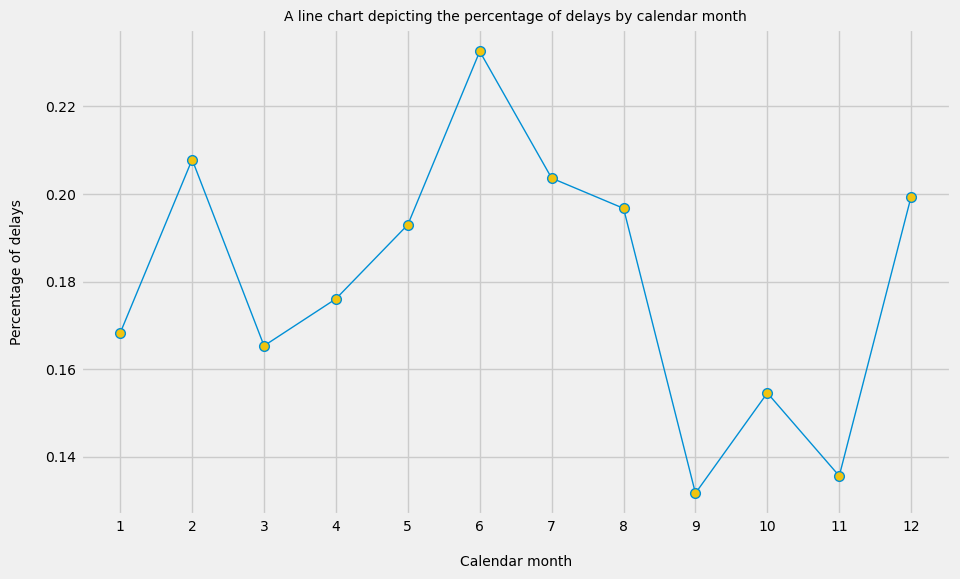

In [11]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(10,6))
plt.plot(flight_delays_by_month_df.index, flight_delays_by_month_df.values, linewidth=1, marker="o", markersize=7, markerfacecolor="#f1c40f")
plt.xlabel('Calendar month', fontsize=10, labelpad=15)
plt.ylabel('Percentage of delays', fontsize=10, labelpad=15)
plt.title('A line chart depicting the percentage of delays by calendar month', fontsize=10)
plt.xticks(range(1, 13), fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True)
plt.show()

### Key Observations
From the line chart depicting the percentage of delays by calendar month, the following conclusions can be drawn:

#### Seasonal Variation in Delays:
<li>The percentage of delays varies across the months, indicating a potential seasonal impact on flight punctuality.</li>
<li>Highest Delay Rates: May (month 5) and December (month 12) exhibit the highest percentages of delays, suggesting potential factors like holiday travel demand, weather conditions, or operational constraints during these periods.</li>
<li>Lowest Delay Rates: September (month 9) has the lowest percentage of delays, indicating it might be a less disruptive month for flights.</li>

#### Summer Peak:
<li>There is a gradual increase in delay percentages from March (month 3) to May (month 5), followed by a decline after the summer months.</li>
<li>This trend aligns with the busy summer travel season, where higher passenger volumes and operational pressures could contribute to delays.</li>

#### End-of-Year Spike:
<li>December shows a sharp rise in delays, likely due to increased travel during the holiday season and potential weather-related disruptions.</li>

#### Relatively Stable Periods:
<li>Months like January (month 1), April (month 4), and October (month 10) have moderate and stable percentages of delays, indicating these could be less affected by seasonal disruptions.</li>

#### Possible Factors:
<li>Travel Demand: Peak travel times (summer and December) seem to correspond with higher delay percentages.</li>
<li>Weather: Seasonal weather conditions, such as storms in summer and winter, might contribute to the trends.</li>
<li>Operational Constraints: Airline and airport capacity could play a role in handling increased demand during peak months.</li>
<br>
This graph suggests a clear seasonal influence on delays, with busy and weather-affected months showing higher disruption rates.

###
### Delays by The Day of The Week

In [12]:
flight_delays_by_weekday_df = flight_df.groupby(flight_df.day_of_week)['is_delayed'].mean()

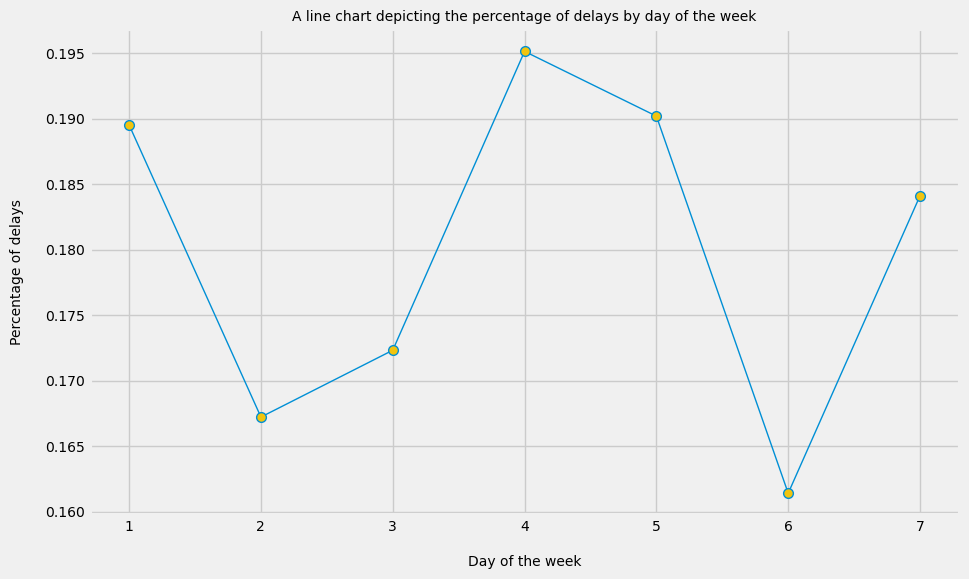

In [13]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(10,6))
plt.plot(flight_delays_by_weekday_df.index, flight_delays_by_weekday_df.values, linewidth=1, marker="o", markersize=7, markerfacecolor="#f1c40f")
plt.xlabel('Day of the week', fontsize=10, labelpad=15)
plt.ylabel('Percentage of delays', fontsize=10, labelpad=15)
plt.title('A line chart depicting the percentage of delays by day of the week', fontsize=10)
plt.xticks(range(1,8), fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True)
plt.show()

### Key Observations
From this graph, the following conclusions can be drawn:

<li>Highest Delay Rates: the highest percentage of delays occurs on Monday (day 1) and Friday (day 5), likely due to the beginning and end of the workweek, when travel demand is higher.</li>

<li>Lowest Delay Rates: Saturday (day 6) has the lowest percentage of delays, possibly because of lower travel volume and operational strain.</li>

<li>Midweek Stability: Tuesday (day 2) and Wednesday (day 3) exhibit relatively low and stable delay percentages, suggesting smoother operations during these days.</li>
<br>
This pattern indicates that flight delays are influenced by weekly travel demand peaks and operational pressures.

###
### Delays by Type of Day of The Week

In [14]:
flight_df['is_weekend'] = flight_df['day_of_week'].apply(lambda x: x in [6, 7])

In [15]:
flight_delays_by_weekend_df = flight_df.groupby('is_weekend')['is_delayed'].mean().round(2)

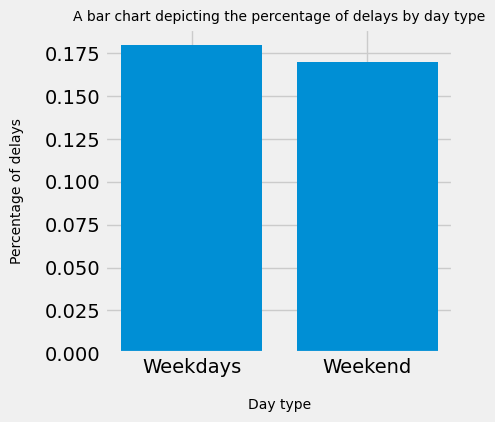

In [16]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(4,4))
plt.bar(['Weekdays', 'Weekend'], flight_delays_by_weekend_df.values)
plt.xlabel('Day type', fontsize=10, labelpad=15)
plt.ylabel('Percentage of delays',fontsize=10, labelpad=15)
plt.title('A bar chart depicting the percentage of delays by day type', fontsize=10)
plt.grid(True)
plt.show()

### Key Observations

From this bar chart, which compares the percentage of delays between weekdays and weekends, the following conclusions can be drawn:

#### Slight Difference in Delays:
<li>The percentage of delays during weekdays is marginally higher compared to the weekend. This suggests that overall, flights are slightly more likely to be delayed on weekdays.</li>

#### Impact of Travel Patterns:
<li>Weekdays generally see higher travel volumes, particularly from business travelers, leading to more congestion and possibly contributing to increased delays.</li>
<li>Weekends may have slightly less air traffic overall, as there is typically a reduction in business travel, allowing for fewer disruptions.</li>

#### Operational Efficiency:
<li>The small difference in delay percentages between weekdays and weekends implies that airline and airport operations are relatively consistent across day types, despite potential differences in traffic volumes.</li>
<br>
While flights are slightly more delayed on weekdays, the difference between weekdays and weekends is not significant, indicating that other factors (e.g., weather, staffing, or specific peak days like Monday and Friday) might have a stronger influence on delays than simply whether it's a weekday or weekend.








###
### Delays by The Flight Distance

<p style='background-color: #FFFFE0; margin-top:20px; padding:5px 15px; font-weight: 500'>Statistical summary of delays</p>

In [17]:
flight_distance_analysis_df = flight_df['distance'].describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]).round(2)
flight_distance_analysis_df

count    7287112.00
mean         803.11
std          594.14
min           31.00
10%          224.00
25%          369.00
50%          641.00
75%         1035.00
90%         1621.00
95%         2171.00
99%         2586.00
max         5095.00
Name: distance, dtype: float64

### Key Observations

Most flights are relatively short to medium in distance (below 900 miles), but there is a significant tail of longer flights, though the very longest flights (over 1300 miles) are rare. The data shows a fair amount of variability in flight distances, with most flights falling in the mid-range.

<p style='background-color: #FFFFE0; margin-top:20px; padding:5px 15px; font-weight: 500'>Defining random sample of 10000 flighs</p>

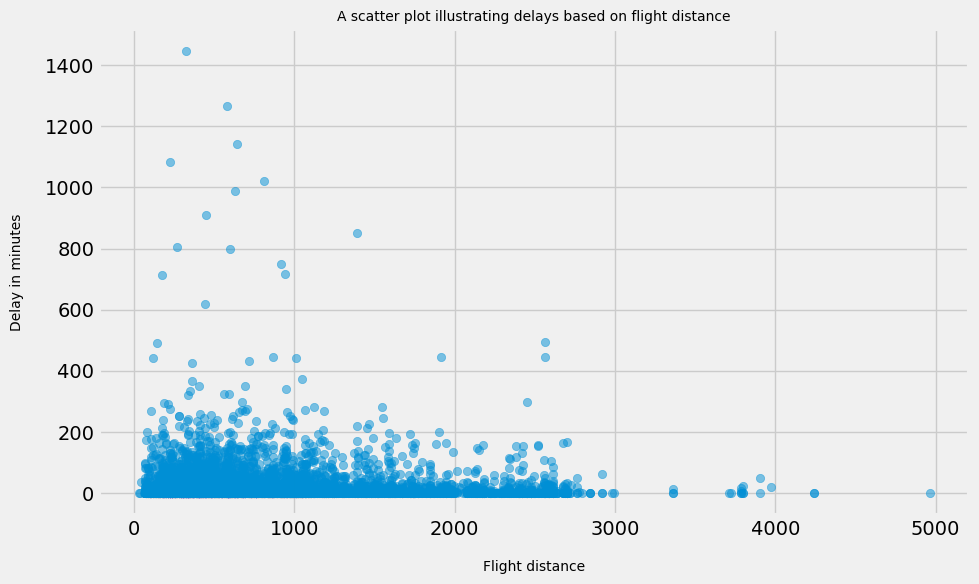

In [18]:
random10k = flight_df.sample(n=10000, random_state=42)

plt.style.use('fivethirtyeight')
plt.figure(figsize=(10,6))
plt.scatter(random10k['distance'], random10k['dep_delay'], alpha=0.5)
plt.xlabel('Flight distance', fontsize=10, labelpad=15)
plt.ylabel('Delay in minutes', fontsize=10, labelpad=15)
plt.title('A scatter plot illustrating delays based on flight distance',fontsize=10)
plt.show()

### Key Observations

<li>Concentration of Points: Most flights, regardless of distance, tend to experience delays below 200 minutes. A dense cluster of points near the origin suggests that shorter flights may be more frequent or generally have lower delays.</li>

<li>Outliers: There are several flights with unusually high delays (over 600 minutes), but these appear to be rare and scattered across varying distances.</li>

<li>No Clear Trend: The scatter plot does not show a strong linear correlation between flight distance and delay. Both short and long flights can have either short or significant delays, suggesting other factors (e.g., weather, airport congestion, or operational issues) might play a larger role.</li>

###
### Delays by The Flight Distance - Further Analysis

<p style='background-color: #FFFFE0; margin-top:20px; padding:5px 15px; font-weight: 500'>Removing rows from the flight_df data frame where distance is above the 95th percentile</p>

In [19]:
distance_95 = flight_df['distance'].quantile(0.95)
flight_df = flight_df[flight_df['distance'] <= distance_95]

<p style='background-color: #FFFFE0; margin-top:20px; padding:5px 15px; font-weight: 500'>Aggregation of the 'distance' variable and calculation of the percentage of delays</p>

In [20]:
distance_agg = pd.cut(flight_df['distance'], bins=range(0, int(distance_95) + 100, 100))
flight_df['distance_agg'] = distance_agg
flight_delays_by_distance_agg_df = flight_df.groupby(distance_agg, observed=True)['is_delayed'].mean()

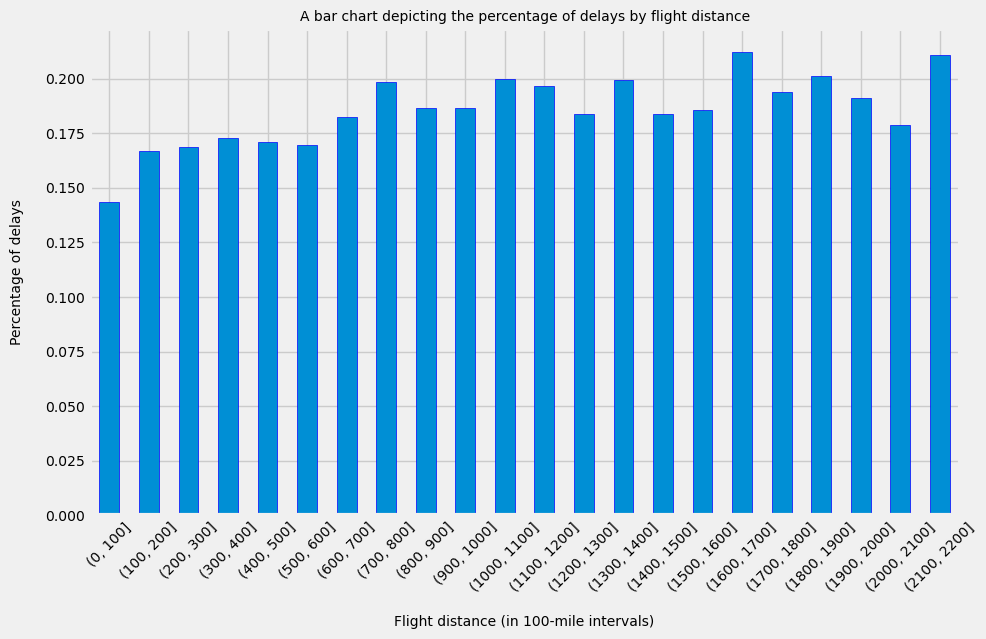

In [21]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(10,6))
flight_delays_by_distance_agg_df.plot(kind='bar', edgecolor='blue')
plt.xlabel('Flight distance (in 100-mile intervals)',fontsize=10, labelpad=15)
plt.ylabel('Percentage of delays',fontsize=10, labelpad=15)
plt.title('A bar chart depicting the percentage of delays by flight distance',fontsize=10)
plt.xticks(rotation=45,fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True)
plt.show()

### Key Observations

#### Shorter Flights Have Fewer Delays:
<li>The percentage of delays is relatively lower for short flights (e.g., distances under 400 miles). This may indicate that shorter flights experience fewer operational complexities, such as congestion at higher altitudes or en-route delays.</li>

#### Mid-Range Flights Have Higher Delay Rates:
<li>Flights with distances between approximately 600–1500 miles show the highest percentage of delays. This could be due to a combination of higher traffic volumes on these popular routes and the potential for delays arising from intermediate factors like air traffic control or weather.</li>

#### Longest Flights Also Face Increased Delays:
<li>For flights over 2000 miles, the delay percentage increases again. This might be explained by the increased likelihood of delays accumulating over longer durations, such as refueling, crew changes, or unfavorable conditions over long-distance routes.</li>

#### Operational and Environmental Factors:
<li>The pattern suggests that flight delays are influenced not just by distance but also by operational factors (e.g., airport congestion, turnaround times) and environmental challenges (e.g., weather, airspace availability).</li>
<br>
While shorter flights generally face fewer delays, mid-range and longer-distance flights tend to experience a higher percentage of delays, likely due to a combination of operational complexity and increased travel time leading to more opportunities for disruptions.

###
### Delays by The Distance Groups

<p style='background-color: #FFFFE0; margin-top:20px; padding:5px 15px; font-weight: 500'>Aggregating the distance variable and calculating the percentage of delays</p>

In [22]:
flight_distance_by_distance_group = flight_df.groupby('distance_group')['distance'].agg(['min', 'max'])

In [23]:
flight_delays_by_distance_group_df = flight_df.groupby('distance_group')['is_delayed'].mean()

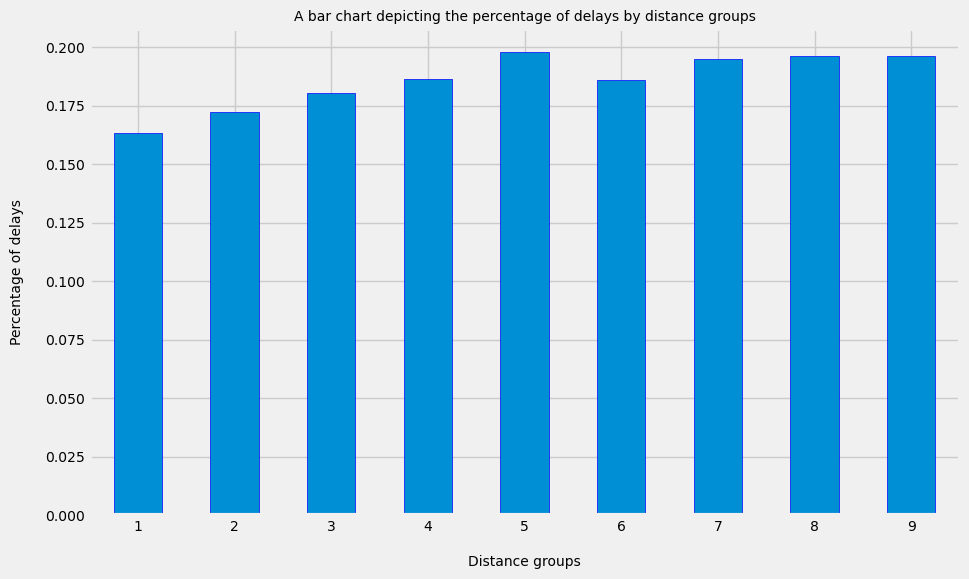

In [24]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(10,6))
flight_delays_by_distance_group_df.plot(kind='bar', edgecolor='blue')
plt.xlabel('Distance groups',fontsize=10, labelpad=15)
plt.ylabel('Percentage of delays',fontsize=10, labelpad=15)
plt.title('A bar chart depicting the percentage of delays by distance groups',fontsize=10)
plt.xticks(rotation=0,fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True)
plt.show()

### Key Observations

#### Uniform Percentage of Delays Across Distance Groups:

<li>The percentage of delays appears relatively consistent across all distance groups. There is no significant drop or spike as the distance group increases, indicating that distance is not a dominant factor influencing the likelihood of delays.</li>

    
#### Slightly Higher Delays in Longer Distance Groups:
<li>The highest percentages of delays are observed in the longer distance groups (e.g., groups 8 and 9). This may indicate that longer flights encounter slightly more operational challenges, such as weather dependencies, scheduling complexities, or resource management.</li>


#### Implications for Airlines:
<li>Since the percentage of delays does not vary drastically with distance, airlines may need to focus on other factors (e.g., airport efficiency, crew readiness, or technical issues) to improve delay metrics across the board.</li>


#### Potential Operational Insights:
<li>Shorter flights (groups 1 and 2) show slightly lower percentages of delays compared to longer-distance groups. This may reflect less susceptibility to external factors like air traffic control restrictions or extended turnaround times.</li>

###
## Notebooks Analysis Summary

Based on the analysis of the delay charts depending on flight distance and distance groups, it can be observed that a greater distance does not necessarily imply a higher likelihood of flight delays.

In the scatter plot, which shows delays based on the exact flight distance, the data appears scattered, with no clear trend indicating a direct relationship between distance and delays. Delays are evident for both short and long distances.

On the other hand, in the bar chart displaying the percentage of delays by distance groups, some groups exhibit higher delay percentages than others. Grouping distances provides a general view of how delays distribute across different distance ranges. This chart suggests that certain distance groups may have a higher likelihood of flight delays, but the relationship is neither linear nor definitive.

The conclusions drawn from both analyses may differ since the scatter plot focuses on specific flight distance values, while the bar chart offers a general overview based on grouped distances. Both charts provide insights, but they are not identical. To better understand the relationship between distance and delays, additional analyses or predictive models may be required.

####
<p style='background-color: #FFFFE0; margin-top:20px; padding:5px 15px; font-weight: 500'>Saving 'flight_df' DataFrame for futher analysis</p>

In [25]:
flight_df.to_csv(f"{DIR_PATH}{os.path.sep}data{os.path.sep}processed{os.path.sep}flight_df_01.csv", index=False)